# Running Monte Carlo over real files

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random 
import urllib.request
import json
from   collections import OrderedDict

import astropy.coordinates as coord
import astropy.units as u
from   astropy import time as t

import poliastro
from poliastro.bodies   import Earth
from poliastro.twobody  import Orbit
from poliastro.plotting import plot

import emcee

# Loading multiple files with a SINGLE satellite

In [2]:
c = 299792.458  # km/s

def GetDopplerShift(f_c, f_m):
    DS = (f_m - f_c)/f_c
    return DS
    
def get_v_radial(f_c, f_m):
    v_r = c * GetDopplerShift(f_c, f_m)
    return v_r

In [3]:
file_list = ['first_test/001_20190721T052832_jena.json',
             'first_test/001_20190721T052821_leipzig.json',
             'first_test/001_20190721T052801_settrup.json',
             'first_test/001_20190721T052806_stuttgart.json']

N = len(file_list)

In [4]:
raw_data = []

for filename in file_list:
    with open( filename, 'r') as myfile:
        data=myfile.read()
        raw_data.append(data)

In [5]:
json_files = []

for i in range(N):
    obj = json.loads(raw_data[i])
    json_files.append(obj)

In [6]:
gs_geodetic_locs = []

for i in range(N):
    gs_geodetic_locs.append( json_files[i]['groundstation'])


# Get Doppler Shift data from F_c and F_m

In [7]:
f_c = obj['data'][0]['channel_f_center']

In [8]:
tau = []
DS = []

for i in range(N):
    
    print("Sat ID: {}".format(json_files[i]['data'][0]['sat_id']))
    stream = json_files[i]['data'][0]['stream']
    
    aux_tau = []
    aux_DS   = []
    
    for s in stream:
        aux_tau.append( float(s['time_system']))
        aux_DS.append( GetDopplerShift(f_c, float(s['f']) ))

    print("Stream length: {}".format(len(aux_DS)))
    tau.append(aux_tau)
    DS.append(aux_DS)

        

Sat ID: 1
Stream length: 396
Sat ID: 1
Stream length: 401
Sat ID: 1
Stream length: 389
Sat ID: 1
Stream length: 392


In [9]:
for i in range(N):
    print(len(tau[i]))

396
401
389
392


### Doppler Shift measured by Ground Stations

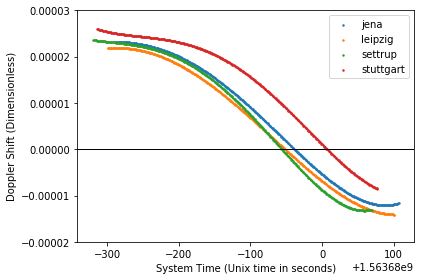

In [10]:
fig = plt.figure(figsize=(6,4))
plt.axhline(0, c="k", lw=1)

for i in range(N):
    
    label = gs_geodetic_locs[i]['gs_name']
    plt.scatter(tau[i], DS[i], s=2, label=label)
    
plt.ylim(-2e-5,3e-5)
plt.xlabel("System Time (Unix time in seconds)")
plt.ylabel("Doppler Shift (Dimensionless)")
plt.legend(loc=0)

plt.tight_layout()
plt.savefig("first_test/measured_doppler_shift.png")

### Calculating GS positions and velocities in the GeoCentric Reference System

In [11]:
gs_geodetic_locs

[{'gs_id': None,
  'gs_name': 'jena',
  'gs_lon': 11.56886,
  'gs_lat': 50.91847,
  'gs_alt': 130.0},
 {'gs_id': None,
  'gs_name': 'leipzig',
  'gs_lon': 12.338261,
  'gs_lat': 51.336569,
  'gs_alt': 80.0},
 {'gs_id': None,
  'gs_name': 'settrup',
  'gs_lon': 7.6289,
  'gs_lat': 52.49356,
  'gs_alt': 40.0},
 {'gs_id': None,
  'gs_name': 'stuttgart',
  'gs_lon': 9.2356,
  'gs_lat': 48.777,
  'gs_alt': 230.0}]

In [12]:
GS = []

for i in range(N):
    lon = gs_geodetic_locs[i]['gs_lon']
    lat = gs_geodetic_locs[i]['gs_lat']
    alt = gs_geodetic_locs[i]['gs_alt']
    
    gs = coord.EarthLocation(lon, lat, alt)
    
    GS.append(gs)

In [13]:
tau_astropytime = []

for i in range(N):
    aux = []
    for aux_t in tau[i]:
        theta = t.Time(aux_t, format='unix', scale='utc')
        aux.append(theta)
    tau_astropytime.append(aux)

In the next cell we calculate the velocity and the position of each ground station at each moment of measurement. It takes around 2 minutes per 400 observations.
In this case around 8 minutes per four stations (~1600 observations)

In [14]:
GS_gcrs_positions = []
GS_gcrs_velocities = []

for  i in range(N):
    aux_pos = []
    aux_vel = []
    
    print("iteration {} starts at time {}".format(i, t.Time.now()))
    for t0 in tau_astropytime[i]:
        p,v = GS[0].get_gcrs_posvel(obstime= t0)
        aux_pos.append(p)
        aux_vel.append(v)
    
    print("iteration {} ends at time {}".format(i, t.Time.now()))
    
    GS_gcrs_positions.append(aux_pos)
    GS_gcrs_velocities.append(aux_vel)

iteration 0 starts at time 2019-08-12 15:33:51.037653
iteration 0 ends at time 2019-08-12 15:35:56.966552
iteration 1 starts at time 2019-08-12 15:35:56.967140
iteration 1 ends at time 2019-08-12 15:38:04.262512
iteration 2 starts at time 2019-08-12 15:38:04.264058
iteration 2 ends at time 2019-08-12 15:40:06.507254
iteration 3 starts at time 2019-08-12 15:40:06.507818
iteration 3 ends at time 2019-08-12 15:42:15.903628


### How it looks:

In [15]:
GS_gcrs_positions[0][:3]

[<CartesianRepresentation (x, y, z) in m
     (4035733.13268396, 145414.70323006, 4920400.43937277)>,
 <CartesianRepresentation (x, y, z) in m
     (4035722.51179125, 145708.32183512, 4920400.46447655)>,
 <CartesianRepresentation (x, y, z) in m
     (4035711.86943215, 146001.93966102, 4920400.48961992)>]

In [16]:
GS_gcrs_velocities[0][:3]

[<CartesianRepresentation (x, y, z) in m / s
     (-10.61036549, 293.61894124, 0.02509544)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.63158776, 293.61823837, 0.02511976)>,
 <CartesianRepresentation (x, y, z) in m / s
     (-10.65305416, 293.61742869, 0.02515935)>]

### Now we have the Ground Station location in XYZ in the Geocentric Inertial System.

Regading, this is the System where Satellite coordinates are measured.

In [17]:
for i in range(N):
    print(len(GS_gcrs_positions[i]), len(GS_gcrs_velocities[i]), len(tau_astropytime[i]))

396 396 396
401 401 401
389 389 389
392 392 392


### Initial position guess:

Well, let's try an XYZ-VxVyVz approximation to the orbital parameters, instead the classic elements.

1. Find average location of Ground Stations: GS_av
2. Extend this vector into space something like 500 km: R0
3. Find some points in a circle into a radius of 1000 km. The circle is centered at R0, in the plane defined by the vector GS_av
4. Define initial velocities towards R0 (or something tangential to Earths Surface).


In [18]:
GS_0x = []
GS_0y = []
GS_0z = []

for i in range(N):
    x, y, z = GS_gcrs_positions[i][0].xyz
    
    GS_0x.append(x.value)
    GS_0y.append(y.value)
    GS_0z.append(z.value)
    
GS_0xav = np.mean(GS_0x)
GS_0yav = np.mean(GS_0y)
GS_0zav = np.mean(GS_0z)

In [19]:
GS_gcrs_positions[0][0]

<CartesianRepresentation (x, y, z) in m
    (4035733.13268396, 145414.70323006, 4920400.43937277)>

In [20]:
GS_av = (GS_0xav, GS_0yav, GS_0zav)
print(GS_av)

(4035908.8008950613, 140423.01365830595, 4920400.021755013)


### Generate the initial positions of Random Walkers

In [21]:
def norm(A_list):
    A = 0
    for a in A_list:
        A += a**2
    return A**0.5

This is the average position of the Ground Stations at the first measurement.

In [22]:
GS_av_unitary = GS_av / norm(GS_av)

This is a point 500 kilometers above the GS_average point.

In [23]:
H_0 = 500 * u.km

Earth.R + H_0

<Quantity 6878136.6 m>

In [24]:
R0 = (Earth.R + H_0) * GS_av_unitary
print(R0)

[4360987.53642076  151733.61009909 5316721.51866248] m


And a random initial velocity, just to test the Orbit Generation from vectors

In [316]:
GM_E = poliastro.constants.GM_earth

V0 = (GM_E / (Earth.R + H_0))**0.5

In [317]:
V0

<Quantity 7612.60839458 m / s>

In [350]:
V0.value

7612.6083945805685

# Orbit generated from vectors

In [290]:
nwalkers = 100
ndim = 6
MCMC_steps = 50

In [389]:
DeltaR0 = 20
DeltaV0 = 5

def init_R0s(R0, nwalkers):
    R0x = R0[0]
    R0y = R0[1]
    R0z = R0[2]
      
    retx = np.random.normal(R0x, DeltaR0, nwalkers)
    rety = np.random.normal(R0y, DeltaR0, nwalkers)
    retz = np.random.normal(R0z, DeltaR0, nwalkers)
    
    ret = np.array([retx, rety, retz])
    return ret.T

def init_V0s(V1, V2, nwalkers):
    
    theta = np.random.random(nwalkers)
    
    A1 = V1 * np.ones([nwalkers, 3]) * V0.value * (np.ones([nwalkers, 3]).T * np.cos( 2 * np.pi * theta) ).T
    A2 = V2 * np.ones([nwalkers, 3]) * V0.value * (np.ones([nwalkers, 3]).T * np.sin( 2 * np.pi * theta) ).T
    
    ret =  A1 + A2
    
    return ret
    

# Likelihood

In [397]:
c = 299792.458 * u.km / u.s

def redshift(f_0, Vradial ):
    
    return f_0 * (1 + Vradial / c)

In [398]:
R = init_R0s( (R0[0].value, R0[1].value, R0[2].value) , nwalkers)
V = init_V0s( v_1, v_2 ,nwalkers)
P0 = np.hstack((R,V))
P0[:,3:]

array([[-2018.44144959, -7101.02545797,  1858.26212603],
       [  885.03762119,  7502.32084604,  -940.05154188],
       [-5782.60897131,  1560.96008181,  4698.57889975],
       [ 5276.15693418,  3251.62147419, -4420.5126811 ],
       [-5539.4905581 ,  2704.82166059,  4466.51885817],
       [-3881.99646366, -5629.74112864,  3344.83554901],
       [ 5679.369668  ,  1869.62001564, -4711.80302437],
       [ 5254.12831848,  3309.07682469, -4404.08364481],
       [ 4208.37535867,  5222.52211113, -3600.92296621],
       [-5606.30169758,  2452.26948812,  4528.52759764],
       [ 5565.13694355, -2611.31159551, -4490.22372716],
       [-5041.68438646, -3810.57647406,  4244.14090858],
       [ 5786.26696622, -1536.0279053 , -4702.29087137],
       [ 5838.32232684,   838.55297439, -4812.75678653],
       [ 5085.50693235,  3714.01046097, -4277.33002071],
       [-4464.63092887, -4855.31220018,  3800.63424667],
       [ 3783.61060293,  5741.14542235, -3267.31489361],
       [-5148.52572241,  3810.1

In [450]:
def lnprob( param ):
    x, y, z, vx, vy, vz = param
    
    r = (x**2 + y**2 + z**2)**0.5
    
    if Earth.R.value > r:        
        print(r)
        return -np.inf
    
    r_init = np.array([x,y,z]) * u.m
    v_init = np.array([vx, vy, vz]) * u.m / u.s
    myOrbit = Orbit.from_vectors(Earth, r_init, v_init)
    
    if(myOrbit.a.value <1):
        print("Negative major semi-axe")
        return -np.inf
        
    #print(myOrbit.ecc)
    
    
    chi2 = 0
    tau_0 = tau_astropytime[0][0]
    
    for i in range(N):
        for t_prime in tau_astropytime[i]:
            DeltaT = t_prime - tau_0
            print(tau_0, t_prime, tau_0- t_prime)


In [451]:
for i in range(1):
    lnprob(P0[i])

1563679712.0000002 1563679712.0000002 0.0
1563679712.0000002 1563679713.0 -1.1574074074038876e-05
1563679712.0000002 1563679714.0 -2.3148148148188774e-05
1563679712.0000002 1563679715.0000002 -3.472222222222765e-05
1563679712.0000002 1563679716.0000002 -4.6296296296266526e-05
1563679712.0000002 1563679717.0 -5.78703703703054e-05
1563679712.0000002 1563679718.0 -6.94444444444553e-05
1563679712.0000002 1563679719.0000002 -8.101851851849418e-05
1563679712.0000002 1563679720.0000002 -9.259259259253305e-05
1563679712.0000002 1563679721.0 -0.00010416666666668295
1563679712.0000002 1563679722.0 -0.00011574074074072183
1563679712.0000002 1563679723.0000002 -0.0001273148148147607
1563679712.0000002 1563679724.0000002 -0.00013888888888879958
1563679712.0000002 1563679725.0 -0.00015046296296294948
1563679712.0000002 1563679726.0 -0.00016203703703698835
1563679712.0000002 1563679727.0000002 -0.00017361111111113825
1563679712.0000002 1563679728.0 -0.00018518518518517713
1563679712.0000002 156367972

1563679712.0000002 1563679868.0000002 -0.0018055555555555047
1563679712.0000002 1563679869.0 -0.0018171296296295436
1563679712.0000002 1563679870.0 -0.0018287037037036935
1563679712.0000002 1563679871.0000002 -0.0018402777777777324
1563679712.0000002 1563679872.0000002 -0.0018518518518518823
1563679712.0000002 1563679873.0 -0.0018634259259259212
1563679712.0000002 1563679874.0 -0.00187499999999996
1563679712.0000002 1563679875.0000002 -0.001886574074073999
1563679712.0000002 1563679876.0000002 -0.0018981481481481488
1563679712.0000002 1563679877.0 -0.0019097222222221877
1563679712.0000002 1563679878.0 -0.0019212962962963376
1563679712.0000002 1563679879.0000002 -0.0019328703703703765
1563679712.0000002 1563679880.0000002 -0.0019444444444444153
1563679712.0000002 1563679881.0 -0.001956018518518454
1563679712.0000002 1563679882.0 -0.001967592592592604
1563679712.0000002 1563679883.0000002 -0.001979166666666643
1563679712.0000002 1563679884.0000002 -0.001990740740740682
1563679712.0000002

1563679712.0000002 1563679737.0 -0.0002893518518518601
1563679712.0000002 1563679738.0 -0.00030092592592589895
1563679712.0000002 1563679739.0000002 -0.00031249999999993783
1563679712.0000002 1563679740.0 -0.0003240740740740877
1563679712.0000002 1563679741.0 -0.0003356481481481266
1563679712.0000002 1563679742.0 -0.0003472222222221655
1563679712.0000002 1563679743.0000002 -0.00035879629629620435
1563679712.0000002 1563679744.0 -0.00037037037037035425
1563679712.0000002 1563679745.0 -0.00038194444444439313
1563679712.0000002 1563679746.0 -0.000393518518518543
1563679712.0000002 1563679747.0000002 -0.0004050925925925819
1563679712.0000002 1563679748.0 -0.0004166666666666208
1563679712.0000002 1563679749.0 -0.00042824074074065965
1563679712.0000002 1563679750.0000002 -0.00043981481481480955
1563679712.0000002 1563679751.0000002 -0.00045138888888884843
1563679712.0000002 1563679752.0 -0.0004629629629629983
1563679712.0000002 1563679753.0 -0.0004745370370370372
1563679712.0000002 156367975

1563679712.0000002 1563680022.0 -0.0035879629629629317
1563679712.0000002 1563680023.0 -0.0035995370370369706
1563679712.0000002 1563680024.0000002 -0.0036111111111111205
1563679712.0000002 1563680025.0 -0.0036226851851851594
1563679712.0000002 1563680026.0 -0.0036342592592591982
1563679712.0000002 1563680027.0000002 -0.003645833333333348
1563679712.0000002 1563680028.0000002 -0.003657407407407387
1563679712.0000002 1563680029.0 -0.003668981481481426
1563679712.0000002 1563680030.0 -0.003680555555555576
1563679712.0000002 1563680031.0000002 -0.0036921296296296147
1563679712.0000002 1563680032.0000002 -0.0037037037037036535
1563679712.0000002 1563680033.0 -0.0037152777777776924
1563679712.0000002 1563680034.0 -0.0037268518518518423
1563679712.0000002 1563680035.0000002 -0.003738425925925881
1563679712.0000002 1563680036.0000002 -0.003750000000000031
1563679712.0000002 1563680037.0 -0.00376157407407407
1563679712.0000002 1563680038.0 -0.003773148148148109
1563679712.0000002 1563680039.00

1563679712.0000002 1563679759.0000002 -0.0005439814814814925
1563679712.0000002 1563679760.0 -0.0005555555555555314
1563679712.0000002 1563679761.0 -0.0005671296296295703
1563679712.0000002 1563679762.0000002 -0.0005787037037036091
1563679712.0000002 1563679763.0000002 -0.000590277777777759
1563679712.0000002 1563679764.0 -0.0006018518518517979
1563679712.0000002 1563679765.0 -0.0006134259259259478
1563679712.0000002 1563679766.0000002 -0.0006249999999999867
1563679712.0000002 1563679767.0 -0.0006365740740740256
1563679712.0000002 1563679768.0 -0.0006481481481480644
1563679712.0000002 1563679769.0 -0.0006597222222222143
1563679712.0000002 1563679770.0000002 -0.0006712962962962532
1563679712.0000002 1563679771.0 -0.0006828703703704031
1563679712.0000002 1563679772.0 -0.000694444444444442
1563679712.0000002 1563679773.0 -0.0007060185185184809
1563679712.0000002 1563679774.0000002 -0.0007175925925925197
1563679712.0000002 1563679775.0 -0.0007291666666666696
1563679712.0000002 1563679776.0

1563679712.0000002 1563679903.0000002 -0.0022106481481480866
1563679712.0000002 1563679904.0 -0.0022222222222222365
1563679712.0000002 1563679905.0 -0.0022337962962962754
1563679712.0000002 1563679906.0000002 -0.0022453703703703143
1563679712.0000002 1563679907.0000002 -0.002256944444444353
1563679712.0000002 1563679908.0 -0.002268518518518503
1563679712.0000002 1563679909.0 -0.002280092592592542
1563679712.0000002 1563679910.0000002 -0.002291666666666692
1563679712.0000002 1563679911.0000002 -0.0023032407407407307
1563679712.0000002 1563679912.0 -0.0023148148148147696
1563679712.0000002 1563679913.0 -0.0023263888888888085
1563679712.0000002 1563679914.0000002 -0.0023379629629629584
1563679712.0000002 1563679915.0000002 -0.0023495370370369972
1563679712.0000002 1563679916.0 -0.002361111111111147
1563679712.0000002 1563679917.0 -0.002372685185185186
1563679712.0000002 1563679918.0000002 -0.002384259259259225
1563679712.0000002 1563679919.0000002 -0.0023958333333332638
1563679712.0000002

1563679712.0000002 1563680059.0000002 -0.004016203703703702
1563679712.0000002 1563680060.0 -0.004027777777777741
1563679712.0000002 1563680061.0 -0.004039351851851891
1563679712.0000002 1563680062.0 -0.00405092592592593
1563679712.0000002 1563680063.0000002 -0.004062499999999969
1563679712.0000002 1563680064.0 -0.004074074074074008
1563679712.0000002 1563680065.0 -0.004085648148148158
1563679712.0000002 1563680066.0000002 -0.0040972222222221966
1563679712.0000002 1563680067.0000002 -0.0041087962962962354
1563679712.0000002 1563680068.0 -0.004120370370370385
1563679712.0000002 1563680069.0 -0.004131944444444424
1563679712.0000002 1563679686.0 0.00030092592592601
1563679712.0000002 1563679687.0 0.0002893518518518601
1563679712.0000002 1563679688.0000002 0.0002777777777778212
1563679712.0000002 1563679689.0 0.0002662037037036713
1563679712.0000002 1563679690.0 0.0002546296296296324
1563679712.0000002 1563679691.0 0.00024305555555559355
1563679712.0000002 1563679692.0000002 0.000231481481

1563679712.0000002 1563679821.0000002 -0.0012615740740740122
1563679712.0000002 1563679822.0 -0.0012731481481481621
1563679712.0000002 1563679823.0 -0.001284722222222201
1563679712.0000002 1563679824.0 -0.0012962962962962399
1563679712.0000002 1563679825.0000002 -0.0013078703703702788
1563679712.0000002 1563679826.0 -0.0013194444444444287
1563679712.0000002 1563679827.0 -0.0013310185185184675
1563679712.0000002 1563679828.0000002 -0.0013425925925926174
1563679712.0000002 1563679829.0000002 -0.0013541666666666563
1563679712.0000002 1563679830.0 -0.0013657407407406952
1563679712.0000002 1563679831.0 -0.001377314814814734
1563679712.0000002 1563679832.0000002 -0.001388888888888884
1563679712.0000002 1563679833.0000002 -0.0014004629629629228
1563679712.0000002 1563679834.0 -0.0014120370370370727
1563679712.0000002 1563679835.0 -0.0014236111111111116
1563679712.0000002 1563679836.0000002 -0.0014351851851851505
1563679712.0000002 1563679837.0000002 -0.0014467592592591894
1563679712.0000002 1

In [496]:
TestOrbit = Orbit.from_vectors(Earth, P0[0][:3] * u.m, P0[0][3:] * u.m/u.s, epoch=tau_astropytime[0][0] )

In [497]:
test_prop = TestOrbit.propagate(DeltaT)

In [498]:
test_prop.r

<Quantity [ 3178.68050814, -2578.95792852,  5527.54967082] km>

In [499]:
TestOrbit.r

<Quantity [4360960.61267721,  151717.93724532, 5316737.71418306] m>

Displacement vectors and velocities are created in the plane defined by the base {v_1, v_2}. Then is rotated to match with the plane defined by the normal vector GS_av.

In [36]:
# Warning: The arguments of np.arctan2 are:
# arctan2( Ycoord , Xcoord )
phi = np.arctan2(GS_av_unitary[1], GS_av_unitary[0])

rho = ( GS_av_unitary[0]**2 + GS_av_unitary[1]**2 )**0.5

theta = np.arctan( GS_av_unitary[2]/ rho )



#theta  = np.pi/2   # Angle (in radians) of rotation around the z axis
#phi    = np.pi/4   # Angle (in radians) of rotation around the x axis
#v_test = np.array([0,0,1])


R_z = np.array([[np.cos(theta), -np.sin(theta), 0],
                [np.sin(theta),  np.cos(theta), 0],
                [            0,              0, 1]])

R_x = np.array([[ 1,           0,            0],
                [ 0, np.cos(phi), -np.sin(phi)],
                [ 0, np.sin(phi),  np.cos(phi)]])

ROTATION = np.matmul(R_x, R_z)

print(ROTATION)

#v_final = ROTATION.dot(v_test)
    
#print( v_final)
#print( norm(v_final))

[[ 0.63441985 -0.77298865  0.        ]
 [ 0.77252119  0.63403619 -0.03477237]
 [ 0.02687864  0.02206028  0.99939526]]


In [37]:

ran = random.random()


In [38]:
radius = 1000 #(km)

u_1 = 1000 # np.cos( 2 * np.pi * ran) * radius
u_2 = 0 # np.sin( 2 * np.pi * ran) * radius
u_3 = 0 # (km)

U = np.array([u_1, u_2, u_3])

speed = 10 #(km/s)

nu_1 = 0 # -np.cos( 2 * np.pi * ran) * speed
nu_2 = 10 # -np.sin( 2 * np.pi * ran) * speed
nu_3 = 0

NU = np.array([nu_1, nu_2, nu_3])

print("Displacement from O", U)
print("Velocity at the point", NU)

Displacement from O [1000    0    0]
Velocity at the point [ 0 10  0]


An initial condition:

In [44]:
R0

<Quantity [4360987.53642076,  151733.61009909, 5316721.51866248] m>

In [45]:
GM_E = poliastro.constants.GM_earth

(GM_E / (Earth.R + H_0))**0.5

<Quantity 7612.60839458 m / s>

In [46]:
# If the perigee is less than Earth Radius.
if( TestOrbit.a * (1-TestOrbit.ecc) < Earth.R):
    print("Orbit fails. crash")
else:
    print("Good orbit!")

Orbit fails. crash
